## 06-BatchNormalization

[1.Batch Distribution](#1)

[2. Batch Normalization](#2)
  - [2-1.Normal NN Distribution](#2-1)

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
import torchvision
import torchvision.transforms as transforms

from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torchsummary import summary

<a id="1"></a>
## 1. Batch Distribution

In [2]:
data_dir = "/home/pervinco/Datasets/cifar10_pytorch"
save_dir = "./runs/cifar10"
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

epochs = 100
batch_size = 64
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [5]:
def plot_kde_distributions(dataloader, num_batches=10):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 10))
    axes = axes.flatten()

    for i, data in enumerate(dataloader, 0):
        if i >= num_batches:
            break
    
        images, labels = data
    
        images = images.view(images.size(0), -1)
        feature1 = images[:, 0] 
        feature2 = images[:, 1] 
    
        sns.kdeplot(feature1.numpy(), ax=axes[i], fill=True, common_norm=False, color="blue", label='Feature 1', alpha=0.5)
        sns.kdeplot(feature2.numpy(), ax=axes[i], fill=True, common_norm=False, color="orange", label='Feature 2', alpha=0.5)
        axes[i].set_title(f'Batch {i+1} Distribution')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

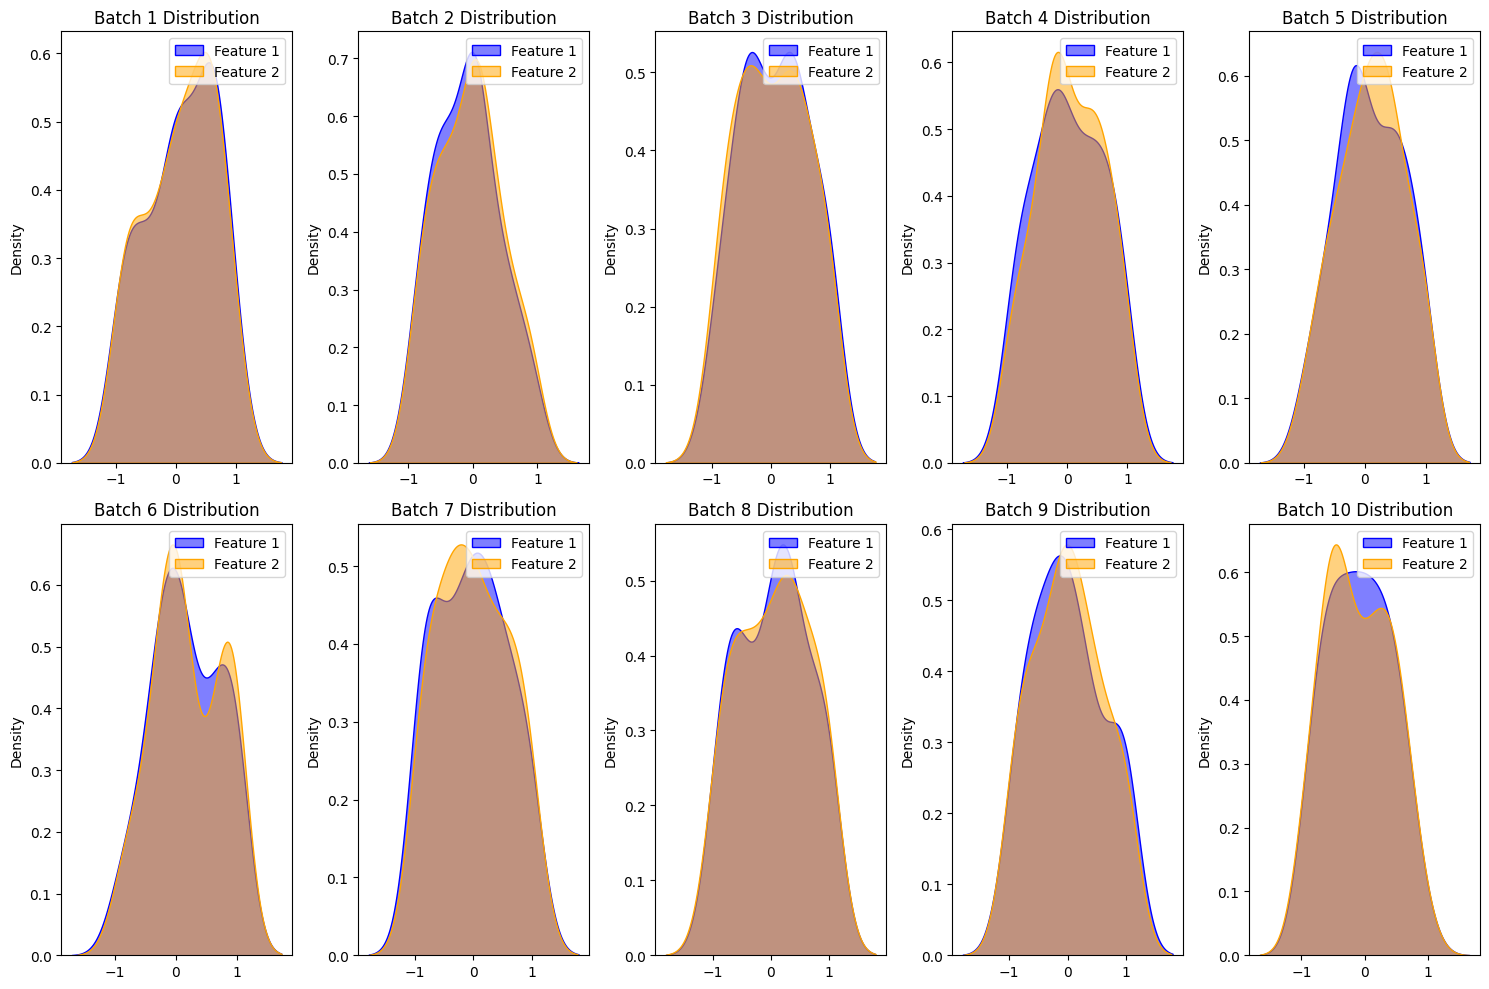

In [6]:
plot_kde_distributions(trainloader)

<a id="2"></a>
## 2.Batch Normalization

<a id="2-1"></a>
### 2-1. Normal NN distribution

In [7]:
class BaselineModel(nn.Module):
    def __init__(self):
        super().__init__()
        ## input : (3, 32, 32)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x) ## (6, 28, 28)
        x = F.relu(x)
        x = self.pool(x) ## (6, 14, 14)

        x = self.conv2(x) ## (16, 10, 10)
        x = F.relu(x)
        x = self.pool(x) ## (16, 5, 5)

        x = torch.flatten(x, 1) ## 16 * 5 * 5 = 1280
        x = F.relu(self.fc1(x)) ## 1280 -> 120
        x = F.relu(self.fc2(x)) ## 120 -> 84
        x = self.fc3(x) ## 84 -> 10

        return x

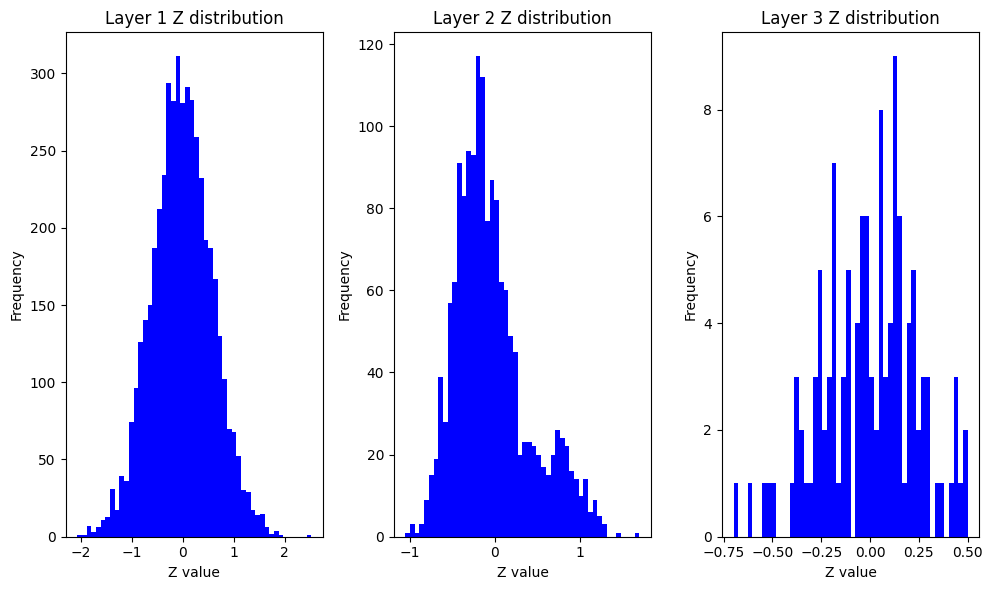

In [8]:
activations = []
def get_activation(layer):
    def hook(model, input, output):
        activations.append(output.detach())
    return hook

model = BaselineModel()

hook1 = model.conv1.register_forward_hook(get_activation(model.conv1))
hook2 = model.conv2.register_forward_hook(get_activation(model.conv2))
hook3 = model.fc1.register_forward_hook(get_activation(model.fc1))

dummy_input = torch.randn(1, 3, 32, 32)
output = model(dummy_input)

hook1.remove()
hook2.remove()
hook3.remove()

plt.figure(figsize=(10, 6))
for i, activation in enumerate(activations):
    plt.subplot(1, len(activations), i+1)
    plt.title(f'Layer {i+1} Z distribution')
    plt.hist(activation.numpy().flatten(), bins=50, color='blue')
    plt.xlabel('Z value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [9]:
model = BaselineModel()
summary(model, input_size=(3, 32, 32), device="cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9) ## SGD + Momentum

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [10]:
model.train()
for epoch in range(epochs):
    train_loss = 0.0
    for data in tqdm(trainloader, desc="Train", leave=False):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad() ## gradient 변수를 0으로 만든다.

        ## forward propagation
        outputs = model(inputs)
        
        ## compute cost
        loss = criterion(outputs, labels)

        ## backpropagation
        loss.backward()

        ## update parameters
        optimizer.step()

        train_loss += loss.item() * inputs.size(0) ## cost는 배치단위 loss의 평균값이므로 총 합으로 되돌린다.

    ## 1epoch은 (전체 데이터 샘플 수 / 배치 사이즈)개의 배치들을 모두 보는 것이므로, 전체 데이터셋의 크기로 train_loss를 나눠준다.
    num_data_samples = len(trainloader.dataset)
    train_loss /= num_data_samples

    if epoch % 10 == 0:
        print(f"epoch {epoch} | Loss : {train_loss:.4f}")

epoch 0 | Loss : 2.3009


epoch 10 | Loss : 1.2951


epoch 20 | Loss : 1.0415


epoch 30 | Loss : 0.8779


epoch 40 | Loss : 0.7492


epoch 50 | Loss : 0.6444


epoch 60 | Loss : 0.5494


epoch 70 | Loss : 0.4600


epoch 80 | Loss : 0.3919


epoch 90 | Loss : 0.3217


In [12]:
model.eval()
total = 0
correct = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 60 %


<a id="2-2"></a>
### 2-2. Batch Normalization NN Dist

In [15]:
class BatchNormModel(nn.Module):
    def __init__(self):
        super().__init__()
        ## input : (3, 32, 32)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.bn1 = nn.BatchNorm2d(6)
        self.bn2 = nn.BatchNorm2d(16)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x) ## (6, 28, 28)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x) ## (6, 14, 14)

        x = self.conv2(x) ## (16, 10, 10)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x) ## (16, 5, 5)

        x = torch.flatten(x, 1) ## 16 * 5 * 5 = 1280

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)

        return x

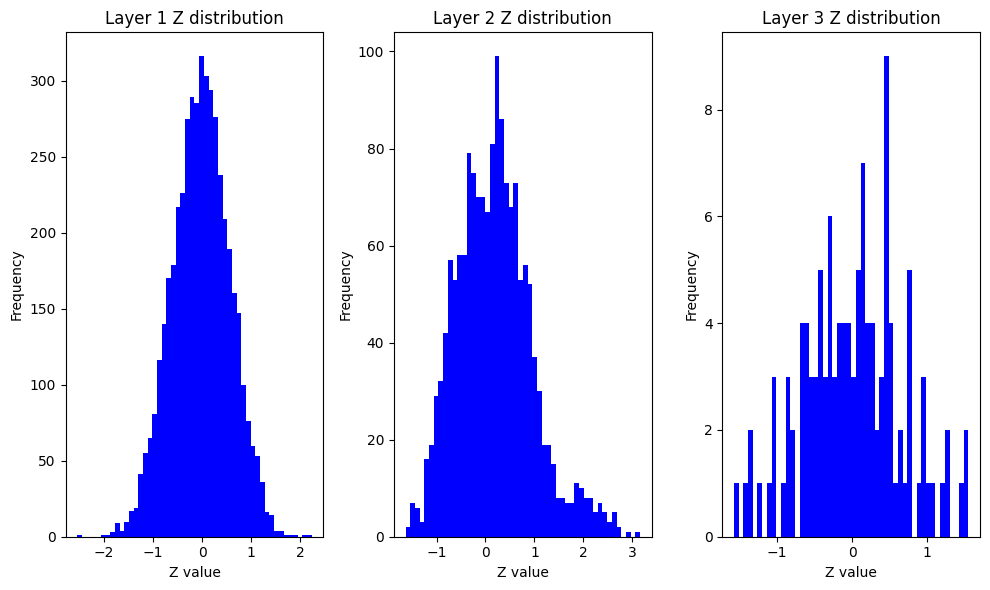

In [17]:
activations = []
def get_activation(layer):
    def hook(model, input, output):
        activations.append(output.detach())
    return hook

bn_model = BatchNormModel()

hook1 = bn_model.conv1.register_forward_hook(get_activation(bn_model.conv1))
hook2 = bn_model.conv2.register_forward_hook(get_activation(bn_model.conv2))
hook3 = bn_model.fc1.register_forward_hook(get_activation(bn_model.fc1))

dummy_input = torch.randn(1, 3, 32, 32)
output = bn_model(dummy_input)

hook1.remove()
hook2.remove()
hook3.remove()

plt.figure(figsize=(10, 6))
for i, activation in enumerate(activations):
    plt.subplot(1, len(activations), i+1)
    plt.title(f'Layer {i+1} Z distribution')
    plt.hist(activation.numpy().flatten(), bins=50, color='blue')
    plt.xlabel('Z value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [18]:
summary(bn_model, input_size=(3, 32, 32), device="cpu")
bn_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(bn_model.parameters(), lr=0.001, momentum=0.9) ## SGD + Momentum

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
       BatchNorm2d-2            [-1, 6, 28, 28]              12
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
       BatchNorm2d-5           [-1, 16, 10, 10]              32
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
            Linear-8                   [-1, 84]          10,164
            Linear-9                   [-1, 10]             850
Total params: 62,050
Trainable params: 62,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.11
Params size (MB): 0.24
Estimated Total Size (MB): 0.36
---------------------------------------------

In [19]:
bn_model.train()
for epoch in range(epochs):
    train_loss = 0.0
    for data in tqdm(trainloader, desc="Train", leave=False):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad() ## gradient 변수를 0으로 만든다.

        ## forward propagation
        outputs = bn_model(inputs)
        
        ## compute cost
        loss = criterion(outputs, labels)

        ## backpropagation
        loss.backward()

        ## update parameters
        optimizer.step()

        train_loss += loss.item() * inputs.size(0) ## cost는 배치단위 loss의 평균값이므로 총 합으로 되돌린다.

    ## 1epoch은 (전체 데이터 샘플 수 / 배치 사이즈)개의 배치들을 모두 보는 것이므로, 전체 데이터셋의 크기로 train_loss를 나눠준다.
    num_data_samples = len(trainloader.dataset)
    train_loss /= num_data_samples

    if epoch % 10 == 0:
        print(f"epoch {epoch} | Loss : {train_loss:.4f}")

epoch 0 | Loss : 1.9633


epoch 10 | Loss : 1.0334


epoch 20 | Loss : 0.8791


epoch 30 | Loss : 0.7549


epoch 40 | Loss : 0.6503


epoch 50 | Loss : 0.5552


epoch 60 | Loss : 0.4769


epoch 70 | Loss : 0.4092


epoch 80 | Loss : 0.3433


epoch 90 | Loss : 0.2959


In [20]:
bn_model.eval()
total = 0
correct = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = bn_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 64 %
